# Before you start
This notebook starts after performing the previous `Q2import_demux_deblur_treebuilding_taxonomy`, which means you should have the following files available:  

`merged_gg-taxonomy.qza` #Greengenes naive-based classifier traind on the V4 region  
`merged_rep-seqs.qza` #rep-seqs following Deblur  
`merged_table.qza` #feature-table from run1 + run 2 merged  
`merged_tree.qza` # sepp insertion tree made with greengenes backbone using the above rep-seqs  
`metadata1.tsv`  # qiita sample metadata,for q2 I changed column `sample.name` to `sample_name` in R first

In [1]:
!qiime tools peek merged_table.qza

UUID:        70a2b5e6-d5f4-4fcd-a41d-46532fcb7a08
Type:        FeatureTable[Frequency]
Data format: BIOMV210DirFmt


In [2]:
import os
import biom
import warnings
import pickle
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table
from skbio import OrdinationResults
from skbio.stats import subsample_counts
from skbio.stats.distance import permanova, anosim, mantel
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.feature_table.actions import rarefy
from qiime2.plugins.diversity.actions import beta_group_significance
from qiime2.plugins.emperor.actions import biplot, plot
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins import demux, deblur, quality_filter, \
                           metadata, feature_table, alignment, \
                           phylogeny, diversity, emperor, feature_classifier, \
                           taxa, composition

from assets.step_wise_anova import run_stepwise_anova
from qiime2.plugins.fragment_insertion.actions import filter_features
warnings.filterwarnings("ignore", category=DeprecationWarning)

# helper functions
from utils.util import (mantel_matched, simulate_depth,
                        all_dists, nested_permanova)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [3]:
# import data
table = q2.Artifact.load('merged_table.qza')
mf = q2.Metadata.load('metadata1.tsv')
tree = q2.Artifact.load('merged_tree.qza')

In [26]:
#Running core-metrics
core_metrics_1k = diversity.pipelines.core_metrics_phylogenetic(table = table,
                                                             phylogeny = tree,
                                                             sampling_depth = 1000,
                                                             metadata = mf)

In [30]:
#visualize unweighted UniFrac
emp_plot1k_uUnifrac = emperor.visualizers.plot(core_metrics_1k.unweighted_unifrac_pcoa_results,
                                        mf)
emp_plot1k_uUnifrac.visualization

<visualization: Visualization uuid: e6967038-b56b-4298-bba4-2aa256f762a2>

In [37]:
#visualize weighted UniFrac
emp_plot1k_wUnifrac = emperor.visualizers.plot(core_metrics_1k.weighted_unifrac_pcoa_results,
                                        mf)
emp_plot1k_wUnifrac.visualization

<visualization: Visualization uuid: 077f1c89-24b0-4127-8801-549532d59ba4>

In [34]:
#visualize Bray-Curtis
emp_plot1k_bray = emperor.visualizers.plot(core_metrics_1k.bray_curtis_pcoa_results,
                                        mf)
emp_plot1k_bray.visualization

<visualization: Visualization uuid: c60e4e3b-d01b-4343-9655-e148e5a2ee3f>

Now looking at 3k rarefy.

In [35]:
#Running core-metrics
core_metrics_3k = diversity.pipelines.core_metrics_phylogenetic(table = table,
                                                             phylogeny = tree,
                                                             sampling_depth = 3000,
                                                             metadata = mf)

In [36]:
#visualize unweighted UniFrac
emp_plot3k_uUnifrac = emperor.visualizers.plot(core_metrics_3k.unweighted_unifrac_pcoa_results,
                                        mf)
emp_plot3k_uUnifrac.visualization

<visualization: Visualization uuid: e3106d1f-a0dd-4398-aef5-06fc678e930a>

In [38]:
#visualize weighted UniFrac
emp_plot3k_wUnifrac = emperor.visualizers.plot(core_metrics_3k.weighted_unifrac_pcoa_results,
                                        mf)
emp_plot3k_wUnifrac.visualization

<visualization: Visualization uuid: 8dcc822c-cc2d-4e5f-9986-3bc41fbbe896>

In [39]:
#visualize Bray-Curtis
emp_plot3k_bray = emperor.visualizers.plot(core_metrics_3k.bray_curtis_pcoa_results,
                                        mf)
emp_plot3k_bray.visualization

<visualization: Visualization uuid: 7e233263-2f5c-4207-a5ff-2cd6ac43065e>

Now looking at 5k rarefy.

In [40]:
#Running core-metrics
core_metrics_5k = diversity.pipelines.core_metrics_phylogenetic(table = table,
                                                             phylogeny = tree,
                                                             sampling_depth = 5000,
                                                             metadata = mf)

In [41]:
#visualize unweighted UniFrac
emp_plot5k_uUnifrac = emperor.visualizers.plot(core_metrics_5k.unweighted_unifrac_pcoa_results,
                                        mf)
emp_plot5k_uUnifrac.visualization

<visualization: Visualization uuid: b5d15cc1-82fa-4b8e-82de-2f52b3295149>

In [43]:
#visualize weighted UniFrac
emp_plot5k_wUnifrac = emperor.visualizers.plot(core_metrics_5k.weighted_unifrac_pcoa_results,
                                        mf)
emp_plot5k_wUnifrac.visualization

<visualization: Visualization uuid: 2aeac4ae-f3a1-4f79-a720-8408a2d8f443>

In [44]:
#visualize Bray-Curtis
emp_plot5k_bray = emperor.visualizers.plot(core_metrics_5k.bray_curtis_pcoa_results,
                                        mf)
emp_plot5k_bray.visualization

<visualization: Visualization uuid: 53227ff5-085c-46ed-812f-6b7b1dbdc247>

## Mantel tests between 2 mix vs 20 min MagMax 
Borrowing from Cam's code here.

In [4]:
# filter only two kits
bt = table.view(Table)
mfdf = mf.to_dataframe()
mfdf = mfdf[mfdf.extraction_kit.isin(['MagMAX Microbiome'])]
shared_ = list(set(bt.ids()) & set(mfdf.index))
mfdf = mfdf.reindex(shared_)
# filter table
bt = bt.filter(shared_)
keep_ = bt.ids('observation')[bt.sum('observation') > 0]
bt.filter(keep_, axis='observation')
# reimport
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
mf = q2.Metadata(mfdf)

### Comparing the 2 min protocl to 20 min protocol of MagMax kits only for now.

In [5]:
# generate dists using all_dissts utils
rare_depth = 5000
dists_res = all_dists(table,
                      rare_depth, tree)

In [6]:
# make a unique ID
mf_dist = mf.to_dataframe().copy()
mf_dist['unique_sample_id'] = ['.'.join(rn_.split('.')[:-2])
                               for rn_ in mf_dist.index]
grouping = 'bead_beating'
ids = 'unique_sample_id'

In [7]:
# run mantel for each distance
mantel_res = {}
for metric_, dist_mantel in dists_res.items():
    # subset mf for dist (rare)
    dist_mantel = dist_mantel.distance_matrix.view(DistanceMatrix)
    mf_dist_sub = mf_dist.reindex(dist_mantel.ids)
    # corr, p, n
    mantel_res[metric_] = mantel_matched(dist_mantel,
                                         mf_dist_sub,
                                         grouping,
                                         ids)

In [330]:
#!mkdir results/
#!mkdir results/tables/

In [8]:
# compile 
mantel_res = pd.DataFrame(mantel_res,
                          ['corr', 'p', 'n'])
mantel_res.to_csv('results/tables/mantel-kits_2min_20min.tsv', sep='\t')
mantel_res

,Jaccard,Unweighted UniFrac,Weighted UniFrac,RPCA
corr,0.953669,0.928896,0.966179,0.913411
p,0.000200,0.000200,0.000200,0.000200
n,137.000000,137.000000,137.000000,137.000000


So we have very high correlation between the two tests which is good.

In [9]:
mf_dist[ids]

sample_name
skin.nares.A.2.1.microbiome2.C                    skin.nares.A.2.1
built.doorknob.D.2.microbiome20.C               built.doorknob.D.2
skin.forehead.eluent.P.1.microbiome2.C    skin.forehead.eluent.P.1
uriM.O.2.microbiome20.L                                   uriM.O.2
oral.throat.eluent.U.microbiome20.C           oral.throat.eluent.U
                                                    ...           
wat.S.A.1.microbiome20.L                                 wat.S.A.1
skin.nares.B.1.1.microbiome2.C                    skin.nares.B.1.1
oral.saline.vtm.A.3.microbiome20.C             oral.saline.vtm.A.3
skin.forehead.B.3.2.microbiome20.C             skin.forehead.B.3.2
skin.nares.D.1.1.microbiome2.C                    skin.nares.D.1.1
Name: unique_sample_id, Length: 576, dtype: object

In [10]:
# get ordinations (row=samples, cols=axes)
pcoa_res = {}
pcoa_res['Jaccard'] = pcoa(dists_res['Jaccard'].distance_matrix).pcoa.view(OrdinationResults).samples
pcoa_res['Unweighted UniFrac'] = pcoa(dists_res['Unweighted UniFrac'].distance_matrix).pcoa.view(OrdinationResults).samples
pcoa_res['Weighted UniFrac'] = pcoa(dists_res['Weighted UniFrac'].distance_matrix).pcoa.view(OrdinationResults).samples
pcoa_res['RPCA'] = dists_res['RPCA'].biplot.view(OrdinationResults).samples


In [11]:
es_all = {}
use_ = ['sample_type', 'sample_type_2','sample_type_3','biomass_sample', 'incubation','sample_technical_replicate', 'bead_beating']
# clean up meta (only stuff to run)
mf_ord = mf.to_dataframe().copy()
# shit filter but works for now
keep_ = [v_ for v_ in mf_ord.columns
         if len(set(mf_ord[v_])) > 1 and
         len(set(mf_ord[v_])) < mf_ord.shape[0]//2]
mf_ord = mf_ord[keep_]
# run stp-wise ANOVA for all ords
for metric_, ord_ in  pcoa_res.items():
    # get first three axes
    ord_ = ord_[[0,1,2]]
    ord_.columns = ['PC1','PC2','PC3']
    # subset/match
    mf_ord_ = mf_ord.copy()
    shared_ids = list(set(ord_.index)\
                      & set(mf_ord_.index))
    mf_ord_ = mf_ord_.loc[shared_ids,:]
    ord_ = ord_.loc[shared_ids,:]
    es_all[metric_] = run_stepwise_anova(ord_, mf_ord_, use_) #mf_ord_.columns)
# concat all runs
es_alldf = pd.concat(es_all).rename({'+ sample_type_2':'Sample Type'}, axis=0)
es_alldf.to_csv('results/tables/effect-size_2min_20min.tsv', sep='\t')
es_alldf


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /home/mestaki/Desktop/post-doc/magmax_comparison/assets/stepwise-rda.R /tmp/tmp1sqqp8k4/ord_.tsv /tmp/tmp1sqqp8k4/mf_.txt /tmp/tmp1sqqp8k4/output.effect.size.tsv

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: /home/mestaki/Desktop/post-doc/magmax_comparison/assets/stepwise-rda.R /tmp/tmpg10q06hu/ord_.tsv /tmp/tmpg10q06hu/mf_.txt /tmp/tmpg10q06hu/output.effect.size.tsv

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will dep

R2.adj  Df         AIC          F  \
Jaccard            + sample_type_3   0.907956  85 -444.599389  47.768527   
                   + incubation      0.006910   1 -475.401064  26.811670   
Unweighted UniFrac + sample_type_3   0.928937  85 -549.116900  62.976966   
                   + incubation      0.002175   1 -560.948711  11.041108   
Weighted UniFrac   + sample_type_3   0.915989  85 -481.495494  52.694256   
                   + biomass_sample  0.003247   1 -496.691615  13.784276   
                   + bead_beating    0.001834   1 -505.247732   8.365581   
RPCA               + sample_type_3   0.918215  85 -492.341302  54.229845   
                   + bead_beating    0.002746   1 -505.409262  12.046378   

                                       Pr(>F)  
Jaccard            + sample_type_3   0.000200  
                   + incubation      0.000200  
Unweighted UniFrac + sample_type_3   0.000200  
                   + incubation      0.000200  
Weighted UniFrac   + sample_type_3   0.000200  
                   + biomass_sample  0.004399  
                   + bead_beating    0.000400  
RPCA               + sample_type_3   0.000200  
                   + bead_beating    0.000200

There appears to be differences between bead_beating, biomass, and incubation with various metrics.

## Comparison of the 2min vs 20 min in resolving differences at different seq. depths

In [338]:
# get table read to start sub-sampling
fold_test = 10
start_depth = 5500
minimum_depth = 500
delta = 250
deviation_depth = 500
bt = table.view(Table)
btdf = pd.DataFrame(bt.matrix_data.toarray(),
                    bt.ids('observation'), bt.ids())
btdf = btdf.T[btdf.sum() > start_depth].T
btdf = btdf[btdf.sum(axis=1) > 0]
btdf.shape

(6689, 396)

In [339]:
# generate tables
depths = np.arange(minimum_depth,
                   start_depth,
                   delta)[::-1] # use depths
depths = {(depth_, fold_):simulate_depth(btdf,
                                depth_,
                                deviation_depth)
          for depth_ in depths
          for fold_ in range(fold_test)} # make table (dict)
len(depths)

200

In [340]:
# first make import tables
btdepths = {depth_:Table(btdf_.values,
                         btdf_.index,
                         btdf_.columns)
            for depth_, btdf_ in depths.items()}
# generate Distances at depth
dists_res = {k_:all_dists(q2.Artifact.import_data('FeatureTable[Frequency]', bt_), k_[0],
                          tree, rpca_depth=0, minf=0)
             for k_, bt_ in btdepths.items()}


In [342]:
# save simulated data as a pickle
!mkdir results/intermediates
with open('results/intermediates/simulations.pickle', 'wb') as handle:
    pickle.dump(btdepths, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('results/intermediates/distances.pickle', 'wb') as handle:
    pickle.dump(dists_res, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
#with open(r"results/intermediates/simulations.pickle", "rb") as input_file:
#    btdepths = pickle.load(input_file)
#with open(r"results/intermediates/simulations.pickle", "rb") as input_file:
#    dists_res = pickle.load(input_file)


In [344]:
# generate PERMANOVA score by detph & kit type
mfdpth = mf.to_dataframe().copy() # (static input)
mfdpth['unique_sample_id'] = ['.'.join(rn_.split('.')[:-2])
                               for rn_ in mfdpth.index]
grouping = 'bead_beating' # (static input)
evaluations = ['sample_type',
               'sample_type_2',
               'sample_type_3',] # (static input)
evals_depths_perm_nest_res = {}
# run everything for each evaluation
for evaluation in evaluations:
    print(evaluation)
    # run for each seq. depth model
    depths_perm_nest_res = {}
    for depth_, dists_res_depth_ in dists_res.items():
        perm_nest_res = {}
        # run kit-nested-PERMANOVA for each distance
        for metric_, distdpth in dists_res_depth_.items():
            distdpth = distdpth.distance_matrix.view(DistanceMatrix).copy()
            perm_nest_res[metric_] = nested_permanova(distdpth, mfdpth,
                                                      grouping, evaluation,
                                                      permutations=2000)
        # save all metrics for depth
        depths_perm_nest_res[depth_] = pd.concat(perm_nest_res)
    # merge to final df
    depths_perm_nest_resdf = pd.concat(depths_perm_nest_res).reset_index()
    depths_perm_nest_resdf = depths_perm_nest_resdf.rename({'level_0':'depth',
                                                            'level_1':'fold',
                                                            'level_2':'metric',
                                                            'level_3':'perm_val_type'},
                                                           axis=1)
    evals_depths_perm_nest_res[evaluation] = depths_perm_nest_resdf
# merge all of evaluation columns
evals_depths_perm_nest_resdf = pd.concat(evals_depths_perm_nest_res).reset_index().drop(['level_1'], axis=1)
evals_depths_perm_nest_resdf = evals_depths_perm_nest_resdf.rename({'level_0':'eval_col'}, axis=1)
evals_depths_perm_nest_resdf.to_csv('results/tables/permanova-depth-evals.tsv', sep='\t')
evals_depths_perm_nest_resdf.head(3)

sample_type
sample_type_2
sample_type_3


,eval_col,depth,fold,metric,perm_val_type,2 min. at 30 Hz,20 min. at 30 Hz
0,sample_type,5250,0,Jaccard,method name,PERMANOVA,PERMANOVA
1,sample_type,5250,0,Jaccard,test statistic name,pseudo-F,pseudo-F
2,sample_type,5250,0,Jaccard,sample size,84,113


In [345]:
sorted(mfdpth.index) != sorted(distdpth.ids)

True

In [360]:
table_rare=core_metrics_5k.rarefied_table

In [362]:
jacrd = beta(table_rare, 'jaccard')
jacrd_ord = pcoa(jacrd.distance_matrix)
uwuni = beta_phylogenetic(table_rare, tree,
                          'unweighted_unifrac')
uwuni_ord = pcoa(uwuni.distance_matrix)
uni = beta_phylogenetic(table_rare, tree,
                        'weighted_unifrac')
uni_ord = pcoa(uni.distance_matrix)
rpca_ord = rpca(table, n_components=8,
                min_feature_count=10,
                min_sample_count=1000)

In [363]:
mfdf.groupby()


TypeError: You have to supply one of 'by' and 'level'

In [364]:
bttmp = table.view(Table)
bttmp = pd.DataFrame(bttmp.matrix_data.toarray(),
                     bttmp.ids('observation'), bttmp.ids())
bttmp = bttmp.T[bttmp.sum() > 2000].T
bttmp = bttmp[bttmp.sum(axis=1) > 0]
bttmp.shape

(7278, 448)

In [365]:
tst = simulate_depth(bttmp, 2000, 500)

In [366]:
bttmp.columns

Index(['skin.forehead.Q.2.1.microbiome2.C',
       'oral.saline.vtm.A.3.microbiome20.C', 'oral.human.R.2.microbiome20.H',
       'built.floor.C.2.microbiome2.C', 'food.sourkraut.2.2.microbiome20.H',
       'oral.throat.B.1.1.microbiome2.C', 'stool.mouse.S.2.microbiome20.H',
       'oral.throat.B.2.1.microbiome2.C', 'skin.forehead.B.3.1.microbiome20.C',
       'bacsu.para.d5.microbiome20.H',
       ...
       'bacsu.para.d2.microbiome2.H', 'oral.human.O.2.microbiome2.H',
       'stool.cat.O.1.microbiome2.H', 'para.d4.1.microbiome2.L',
       'wat.F.B.2.microbiome2.L', 'para.d5.1.microbiome2.L',
       'soil.rhizosphere.K.2.microbiome2.H', 'food.yogurt.4.3.microbiome2.H',
       'wat.F.B.2.microbiome20.L', 'wat.S.A.1.microbiome2.L'],
      dtype='object', length=448)

In [367]:
permanova(jacrd.distance_matrix.view(DistanceMatrix),
          mfdf['bead_beating'], permutations=5000)

ValueError: Grouping vector size must match the number of IDs in the distance matrix.

In [357]:
permanova(uni.distance_matrix.view(DistanceMatrix),
          mfdf['extraction_kit'], permutations=5000)

NameError: name 'uni' is not defined

<artifact: FeatureTable[Frequency] uuid: df95f332-2c58-4f42-a40b-97941eb3e0c0>

# Visualization

In [368]:
import os
import biom
import warnings
import numpy as np
import pandas as pd
import qiime2 as q2

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

In [369]:
# import PERM res
permdf = pd.read_csv('results/tables/permanova-depth-evals.tsv',
                     sep='\t', index_col=0)
permdf = permdf[permdf.eval_col.isin(['sample_type_2','sample_type_3'])]
permdfF = permdf[permdf.perm_val_type == 'test statistic']
permdfP = permdf[permdf.perm_val_type == 'p-value']
permdfF[['2 min. at 30 Hz','20 min. at 30 Hz']] = permdfF[['2 min. at 30 Hz','20 min. at 30 Hz']].astype(float)
permdfF['depth'] = permdfF['depth'].astype(int).values
permdfP[['2 min. at 30 Hz','20 min. at 30 Hz']] = permdfP[['2 min. at 30 Hz','20 min. at 30 Hz']].astype(float)
permdfP['depth'] = permdfP['depth'].astype(int).values
permdfP_groups = {eval_:pltdf_ for eval_, pltdf_ in permdfP.groupby(['metric','eval_col'])}
permdf.head(3)

,eval_col,depth,fold,metric,perm_val_type,2 min. at 30 Hz,20 min. at 30 Hz
5600,sample_type_2,5250,0,Jaccard,method name,PERMANOVA,PERMANOVA
5601,sample_type_2,5250,0,Jaccard,test statistic name,pseudo-F,pseudo-F
5602,sample_type_2,5250,0,Jaccard,sample size,84,113


In [370]:
list(set(permdf.metric))

['Weighted UniFrac', 'Unweighted UniFrac', 'Jaccard', 'RPCA']

Weighted UniFrac
2 min. at 30 Hz 500
20 min. at 30 Hz 500
2 min. at 30 Hz 500
20 min. at 30 Hz 500


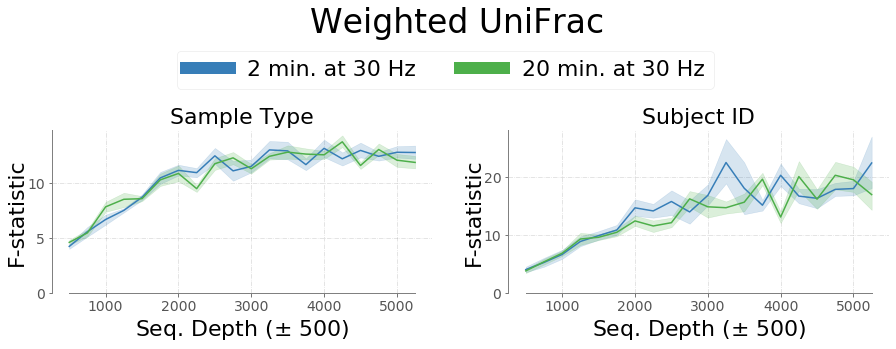

Unweighted UniFrac
2 min. at 30 Hz 500
20 min. at 30 Hz 500
2 min. at 30 Hz 500
20 min. at 30 Hz 500


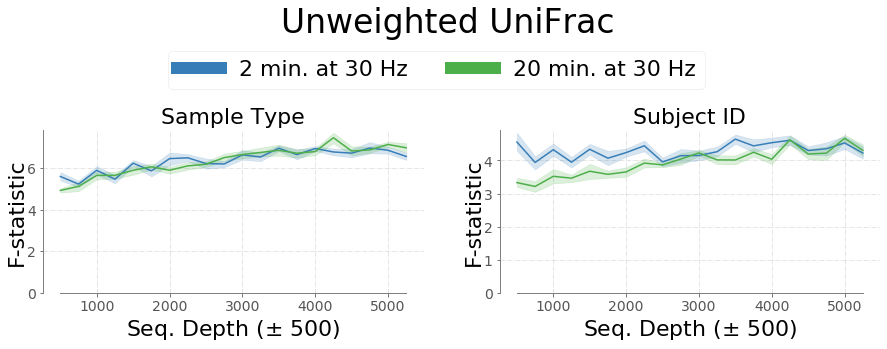

Jaccard
2 min. at 30 Hz 500
20 min. at 30 Hz 500
2 min. at 30 Hz 500
20 min. at 30 Hz 500


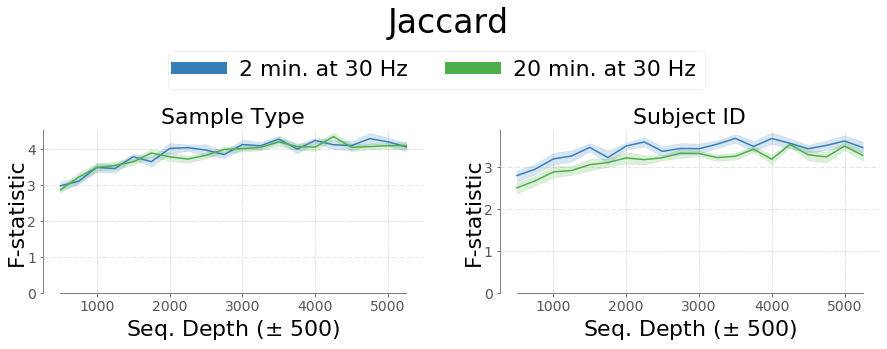

RPCA
2 min. at 30 Hz 500
20 min. at 30 Hz 500
2 min. at 30 Hz 500
20 min. at 30 Hz 500


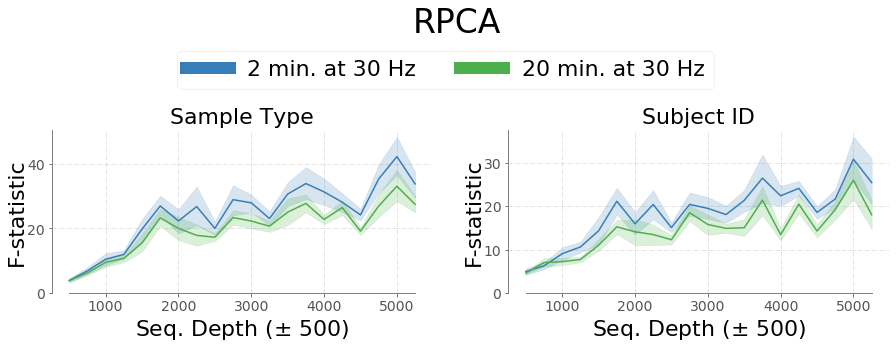

In [372]:
!mkdir results/figures
plt.style.use('ggplot')
#paper_rc = {'lines.linewidth': 2, 
#            'lines.markersize': 5}                  
#sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
rename_title = {'sample_type_2':'Sample Type',
                'sample_type_3':'Subject ID'}
pall_ = {'2 min. at 30 Hz':'#377eb8',
         '20 min. at 30 Hz':'#4daf4a'}

#['Weighted UniFrac', 'Unweighted UniFrac']
title_fontsize=22
for metric_ in list(set(permdf.metric)) :
    print(metric_)
    fig, axn = plt.subplots(1,2, figsize=(15, 3))

    # subset col
    for (eval_, pltdf_), ax in zip(permdfF.groupby('eval_col'), axn):

        # subset datasets
        others_ = ['eval_col','depth','metric','perm_val_type']
        stack_ = ['2 min. at 30 Hz','20 min. at 30 Hz']
        pltdf_ = pltdf_[pltdf_.metric.isin([metric_])]
        plotsatckeddf = []
        # stack the dataframe
        for v_ in stack_:
            tmp_ = pltdf_[others_ + [v_]].rename({v_:'values'} ,axis=1)
            tmp_['kit'] = v_
            plotsatckeddf.append(tmp_)
        # print  
        permdfP_tmp = permdfP_groups[(metric_, eval_)]
        for stack_tmp in stack_:
            permdfP_tmp_ = permdfP_tmp[['depth', stack_tmp]]
            permdfP_tmp_ = permdfP_tmp_.groupby('depth').max()
            pthresh = permdfP_tmp_[permdfP_tmp_ < 0.05].index.min()
            print(stack_tmp, pthresh)
        # stack them
        plotsatckeddf = pd.concat(plotsatckeddf)
        # plot
        sns.lineplot(y='values',
                      x='depth',
                      hue='kit',
                      ci=68,
                      palette=pall_,
                      data=plotsatckeddf, ax=ax)
        ax.set_title(rename_title[eval_], fontsize=22)
        ax.set_xlabel('Seq. Depth ($\pm$ 500)', color='#000000',
                      fontsize=22)
        ax.set_ylabel('F-statistic', color='#000000',
                      fontsize=22, labelpad=0)
        ax.set_ylim(0,)
        # remove all grids, backrounds etc ...
        ax.legend_.remove()        
        ax.set_facecolor('white')
        ax.grid(color='grey',
                linestyle='-.', 
                alpha=0.3,
                linewidth=0.7)
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_bounds(500, 5250)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')
    # generate legend from last iterations     
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[1:], labels[1:], loc=2, 
                             bbox_to_anchor=(-.90, 1.55),
                             prop={'size':22},
                             fancybox=True, framealpha=0.5, 
                             ncol=3, markerscale=3,
                             facecolor="white")

    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(12.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(12.0)
    # set the backrounf to be transparent
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.0)
    # metric
    plt.suptitle(metric_, fontsize=33, y=1.45)
    
    # save the figure to file
    plt.savefig('results/figures/depth-permanova-%s-compare.pdf' % (metric_),dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

    plt.show()

# Repeating above analysis but first stratifying based on low vs high biomass

In [14]:
low_table = feature_table.methods.filter_samples(table,
                                                  metadata = mf,
                                                  where = "biomass_sample='low'")

<visualization: Visualization uuid: 686299f0-5d46-4857-89e0-20e664584377>

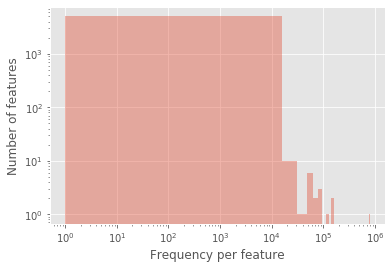

In [15]:
low_table_viz = feature_table.visualizers.summarize(low_table.filtered_table,
                                                   sample_metadata = mf,)
low_table_viz.visualization

In [17]:
#Running core-metrics
low_core_metrics_1k = diversity.pipelines.core_metrics_phylogenetic(low_table.filtered_table,
                                                             phylogeny = tree,
                                                             sampling_depth = 1000,
                                                             metadata = mf)

KeyError: 'There are samples not included in the sample mapping file. Override this error by using the `ignore_missing_samples` argument. Showing only the first 5 samples out of 94: built.doorknob.A.2.qiagen.L, built.doorknob.A.3.qiagen.L, built.doorknob.B.1.qiagen.L, built.doorknob.B.2.qiagen.L, built.doorknob.C.1.qiagen.C ...'

In [11]:
#visualize unweighted UniFrac of low biomass samples only
low_emp_plot1k_uUnifrac = emperor.visualizers.plot(low_core_metrics_1k.unweighted_unifrac_pcoa_results,
                                        mf)
low_emp_plot1k_uUnifrac.visualization

<visualization: Visualization uuid: c5f68c5a-079f-4b07-b8d5-cba4e25d657e>

In [392]:
#visualize Weighted UniFrac of low biomass samples only
low_emp_plot1k_wUnifrac = emperor.visualizers.plot(low_core_metrics_1k.weighted_unifrac_pcoa_results,
                                        mf)
low_emp_plot1k_wUnifrac.visualization

<visualization: Visualization uuid: 47d904ca-1db2-42f3-89e6-7fa1e3768c0e>

In [12]:
#visualize Bray-Curtis of low biomass samples only
low_emp_plot1k_bray = emperor.visualizers.plot(low_core_metrics_1k.bray_curtis_pcoa_results,
                                        mf)
low_emp_plot1k_bray.visualization

<visualization: Visualization uuid: 3d7eeef6-6d1a-4e09-a80f-f8d2639617ed>

In [ ]:
#visualize unweighted UniFrac of low biomass samples only
low_emp_plot3k_uUnifrac = emperor.visualizers.plot(low_core_metrics_3k.unweighted_unifrac_pcoa_results,
                                        mf)
low_emp_plot3k_uUnifrac.visualization